
# 🧪 Variational Autoencoder (VAE) on MNIST — Step by Step

This notebook teaches you the **magic of VAEs** by building and training one on **MNIST**.
We’ll go **cell-by-cell**:
1. Setup & imports  
2. Hyperparameters  
3. Load MNIST  
4. Define the VAE (Encoder → μ, logσ²; Reparameterization; Decoder)  
5. Loss (ELBO = Reconstruction + KL)  
6. Train  
7. Reconstructions  
8. Random sampling  
9. Latent space visualization (when `latent_dim=2`)  
10. Interpolation between two digits

> **Tip:** Use a GPU runtime in Colab: `Runtime → Change runtime type → GPU`.


In [1]:

#@title 1) Setup & Imports
!pip -q install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121 >/dev/null

import os, math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [2]:

#@title 2) Hyperparameters (feel free to tweak)
latent_dim = 2        #@param {type:"integer"}
hidden_dim1 = 512     #@param {type:"integer"}
hidden_dim2 = 256     #@param {type:"integer"}
batch_size = 128      #@param {type:"integer"}
epochs = 8            #@param {type:"integer"}
lr = 1e-3             #@param {type:"number"}
seed = 42             #@param {type:"integer"}

torch.manual_seed(seed)
random.seed(seed)


In [3]:

#@title 3) Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # scales to [0,1]
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} images | Test: {len(test_ds)} images")


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.05MB/s]

Train: 60000 images | Test: 10000 images


In [4]:

#@title 4) Define the VAE (MLP for simplicity)

class Encoder(nn.Module):
    def __init__(self, latent_dim, hidden1=512, hidden2=256):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.mu = nn.Linear(hidden2, latent_dim)
        self.logvar = nn.Linear(hidden2, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden2=256, hidden1=512):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden2)
        self.fc2 = nn.Linear(hidden2, hidden1)
        self.out = nn.Linear(hidden1, 28*28)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        # We return logits; we will use BCEWithLogits (numerically stable)
        logits = self.out(h)
        return logits.view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim, hidden1=hidden_dim1, hidden2=hidden_dim2)
        self.decoder = Decoder(latent_dim, hidden2=hidden_dim2, hidden1=hidden_dim1)

    def reparameterize(self, mu, logvar):
        # z = mu + sigma * eps, where eps ~ N(0, I)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_logits = self.decoder(z)
        return recon_logits, mu, logvar

model = VAE(latent_dim).to(device)
print(model)


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (logvar): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [5]:

#@title 5) Loss = Reconstruction + KL (ELBO)
def elbo_loss(recon_logits, x, mu, logvar):
    # Reconstruction: binary cross-entropy with logits
    recon_loss = F.binary_cross_entropy_with_logits(recon_logits, x, reduction='sum')
    # KL Divergence term (per batch): D_KL(q(z|x) || p(z)) for diagonal Gaussians
    # = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalize by batch size to keep scales stable
    batch_size = x.size(0)
    return (recon_loss + kl) / batch_size, recon_loss / batch_size, kl / batch_size


In [6]:

#@title 6) Train
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_history = []
test_history = []

def evaluate(loader):
    model.eval()
    tot, tot_rec, tot_kl, n = 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon_logits, mu, logvar = model(x)
            loss, rec, kl = elbo_loss(recon_logits, x, mu, logvar)
            bs = x.size(0); n += bs
            tot += loss.item() * bs
            tot_rec += rec.item() * bs
            tot_kl += kl.item() * bs
    return tot/n, tot_rec/n, tot_kl/n

for epoch in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    running = []
    for x, _ in pbar:
        x = x.to(device)
        optimizer.zero_grad()
        recon_logits, mu, logvar = model(x)
        loss, rec, kl = elbo_loss(recon_logits, x, mu, logvar)
        loss.backward()
        optimizer.step()
        running.append(loss.item())
        pbar.set_postfix(loss=f"{sum(running)/len(running):.3f}", rec=f"{rec.item():.3f}", kl=f"{kl.item():.3f}")

    tr = evaluate(train_loader)
    te = evaluate(test_loader)
    train_history.append(tr)
    test_history.append(te)
    print(f"Epoch {epoch}: train loss={tr[0]:.3f} (rec {tr[1]:.3f}, kl {tr[2]:.3f}) | "
          f"test loss={te[0]:.3f} (rec {te[1]:.3f}, kl {te[2]:.3f})")


Epoch 1/8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: train loss=163.684 (rec 158.340, kl 5.344) | test loss=163.473 (rec 158.104, kl 5.369)


Epoch 2/8:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad0f3f9a8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ad0f3f9a8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()if w.is_alive():
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():
          ^  ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 2: train loss=156.914 (rec 151.521, kl 5.394) | test loss=157.009 (rec 151.642, kl 5.368)


Epoch 3/8:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad0f3f9a8e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ad0f3f9a8e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^^
^ ^  ^^  ^^  
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^  ^  ^  ^ 
  File "/usr

Epoch 3: train loss=153.105 (rec 147.152, kl 5.953) | test loss=153.521 (rec 147.609, kl 5.912)


Epoch 4/8:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad0f3f9a8e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ad0f3f9a8e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():  
          ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^
 
  File "/usr/lib/pytho

Epoch 4: train loss=150.003 (rec 144.231, kl 5.772) | test loss=150.524 (rec 144.773, kl 5.751)


Epoch 5/8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: train loss=147.709 (rec 141.601, kl 6.107) | test loss=148.521 (rec 142.441, kl 6.080)


Epoch 6/8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: train loss=146.297 (rec 140.270, kl 6.026) | test loss=147.122 (rec 141.137, kl 5.985)


Epoch 7/8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: train loss=145.212 (rec 138.756, kl 6.456) | test loss=146.005 (rec 139.587, kl 6.418)


Epoch 8/8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: train loss=144.543 (rec 138.102, kl 6.441) | test loss=145.195 (rec 138.792, kl 6.403)


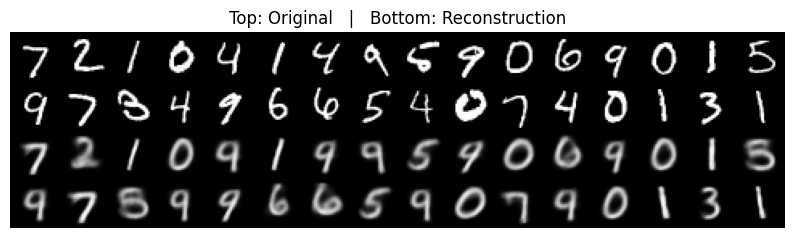

In [7]:

#@title 7) Reconstructions (original vs reconstructed)
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)[:32]
with torch.no_grad():
    recon_logits, mu, logvar = model(x)
    recon = torch.sigmoid(recon_logits)

# create a grid: first row originals, second row reconstructions
grid = torch.cat([x, recon], dim=0).cpu()
grid = vutils.make_grid(grid, nrow=16, padding=2)
plt.figure(figsize=(10,4))
plt.title("Top: Original   |   Bottom: Reconstruction")
plt.axis('off')
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.show()


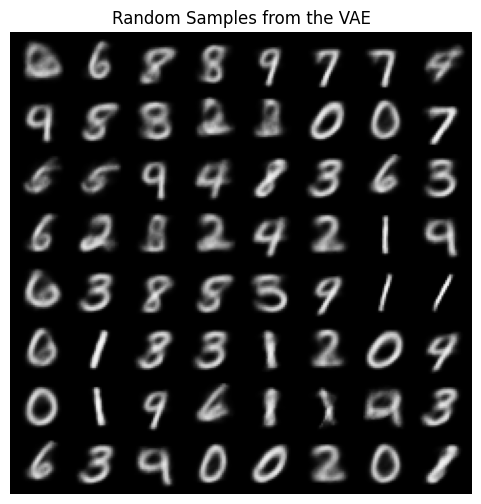

In [8]:

#@title 8) Random Sampling from Prior p(z) = N(0, I)
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    samples = torch.sigmoid(model.decoder(z))

grid = vutils.make_grid(samples.cpu(), nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.title("Random Samples from the VAE")
plt.axis('off')
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.show()


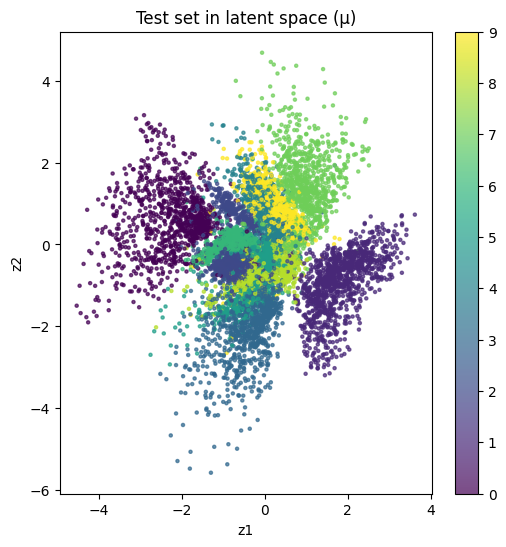

In [9]:

#@title 9) Latent Space (works best when latent_dim = 2)
if latent_dim == 2:
    model.eval()
    mus = []
    labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, logvar = model.encoder(x)
            mus.append(mu.cpu())
            labels.append(y)
    mus = torch.cat(mus).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(6,6))
    plt.scatter(mus[:,0], mus[:,1], c=labels, s=5, alpha=0.7)
    plt.colorbar()
    plt.title("Test set in latent space (μ)")
    plt.xlabel("z1"); plt.ylabel("z2")
    plt.show()
else:
    print("Set latent_dim = 2 to see a 2D latent space scatter plot.")


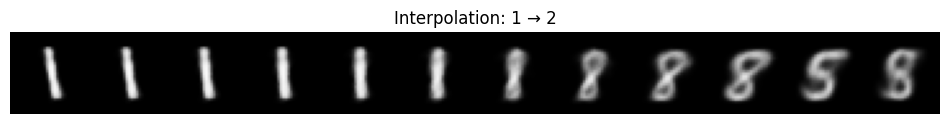

In [17]:

#@title 10) Interpolation between two test digits
def encode_mu(x):
    with torch.no_grad():
        mu, logvar = model.encoder(x)
    return mu

# pick two random test digits
model.eval()
(xa, ya), (xb, yb) = test_ds[random.randrange(len(test_ds))], test_ds[random.randrange(len(test_ds))]
xa = xa.unsqueeze(0).to(device)
xb = xb.unsqueeze(0).to(device)

za = encode_mu(xa)
zb = encode_mu(xb)

steps = 12
alphas = torch.linspace(0, 1, steps, device=device).unsqueeze(1)
zs = (1 - alphas) * za + alphas * zb

with torch.no_grad():
    recon = torch.sigmoid(model.decoder(zs)).cpu()

grid = vutils.make_grid(recon, nrow=steps, padding=2)
plt.figure(figsize=(12,2))
plt.title(f"Interpolation: {ya} → {yb}")
plt.axis('off')
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.show()


In [ ]:

#@title (Optional) Save model weights
os.makedirs('checkpoints', exist_ok=True)
path = f'checkpoints/vae_mnist_latent{latent_dim}.pt'
torch.save(model.state_dict(), path)
print("Saved:", path)
